In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow_decision_forests as tfdf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
dataset = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
dataset = dataset.map(lambda x: int(x) if isinstance(x,bool) else x)

tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="Transported")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

#print(model.summary())

Use /tmp/tmpb3i4n59q as temporary training directory
Reading training dataset...
Training dataset read in 0:00:05.247349. Found 8693 examples.
Training model...
Model trained in 0:00:04.108229
Compiling model...
Model compiled.


# Imports


In [3]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# EXPLORATION


In [4]:
dataset_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (8693, 14)


In [5]:
#dataset_df.head(5)

In [6]:
#print(dataset_df.describe())
#dataset_df.info()

In [7]:
dataset_df = dataset_df.drop(['PassengerId', 'Name'], axis=1)

In [8]:
#dataset_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = dataset_df[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
dataset_df.isnull().sum().sort_values(ascending=False)

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
Transported       0
dtype: int64

In [9]:
dataset_df = dataset_df.map(lambda x: int(x) if isinstance(x,bool) else x)

In [10]:
dataset_df[["Deck", "Cabin_num", "Side"]] = dataset_df["Cabin"].str.split("/", expand=True)
try:
    dataset_df = dataset_df.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")

In [11]:
#dataset_df.head(5)

# More visualisation

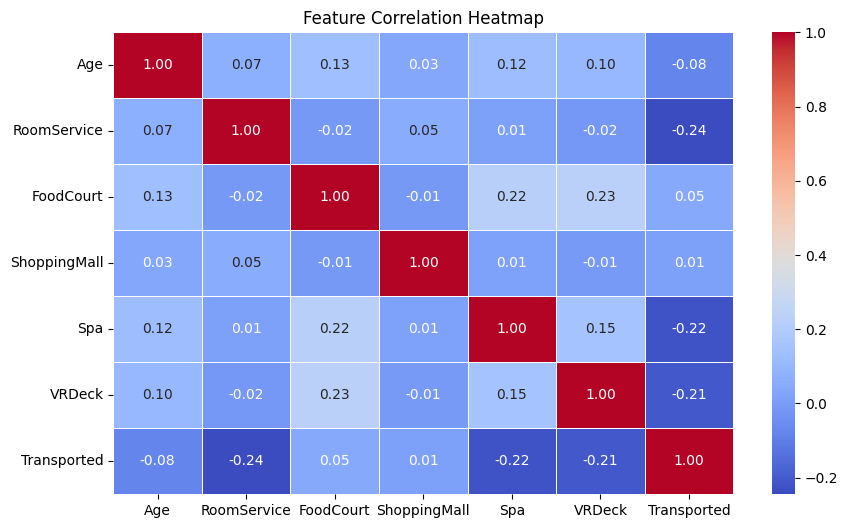

In [12]:
# 1. Correlation Heatmap for numerical features
plt.figure(figsize=(10,6))
num_cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Transported"]
sns.heatmap(dataset_df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# 3. Feature Distributions by Target
fig, axes = plt.subplots(2, 3, figsize=(15,10))
num_features = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
for i, feature in enumerate(num_features):
    sns.histplot(data=dataset_df, x=feature, hue="Transported", element="step", kde=True, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"{feature} Distribution by Transported")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

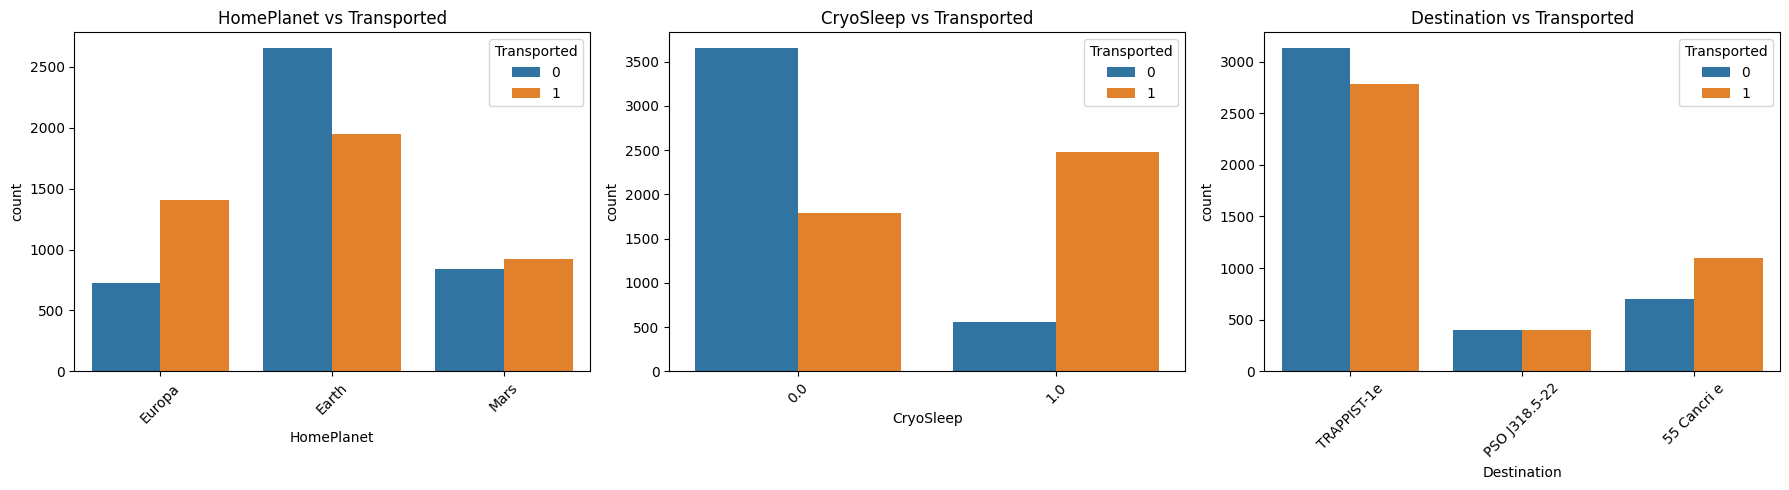

In [14]:
# 5. Categorical Feature Impact
fig, axes = plt.subplots(1, 3, figsize=(18,5))
categories = ["HomePlanet", "CryoSleep", "Destination"]
for i, cat in enumerate(categories):
    sns.countplot(data=dataset_df, x=cat, hue="Transported", ax=axes[i], palette=["#1f77b4", "#ff7f0e"])
    axes[i].set_title(f"{cat} vs Transported")
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Working on features


Replace NaN with median (for numerical) and most frequent (for categorical)

In [15]:
import pandas as pd

# Copy the dataset
cleaned_df = dataset_df.copy()

# List of numerical and categorical columns
numerical_columns = ['RoomService', 'Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_num']
categorical_columns = ['HomePlanet', 'CryoSleep', 'Deck', 'Side', 'Destination', 'VIP', 'Name']

# Check if 'Name' column exists in the DataFrame, and remove it from categorical_columns if it's missing
if 'Name' not in cleaned_df.columns:
    categorical_columns.remove('Name')

# Handle potential non-numeric issues in 'Cabin_num' by converting it to numeric
cleaned_df['Cabin_num'] = pd.to_numeric(cleaned_df['Cabin_num'], errors='coerce')

# Fill numerical columns with median (direct assignment)
for col in numerical_columns:
    cleaned_df[col] = cleaned_df[col].fillna(cleaned_df[col].median())

# Fill categorical columns with the most frequent value (direct assignment)
for col in categorical_columns:
    cleaned_df[col] = cleaned_df[col].fillna(cleaned_df[col].mode()[0])

In [16]:
#dataset_df["TotalSpending"] = dataset_df["VRDeck"] + dataset_df["Spa"] + dataset_df["RoomService"]
#dataset_df["SpentMoney"] = (dataset_df["TotalSpending"] > 0).astype(int)

In [17]:
#from sklearn.decomposition import PCA  
#from sklearn.preprocessing import StandardScaler  

# Standardize the correlated features
#scaler = StandardScaler()
#spending_features = cleaned_df[["VRDeck", "Spa", "RoomService"]].fillna(0)  # Fill NaNs if needed
#spending_scaled = scaler.fit_transform(spending_features)

# Apply PCA
#pca = PCA(n_components=1)  # Reduce to 1 feature
#cleaned_df["Spending_PCA"] = pca.fit_transform(spending_scaled)

# Drop the original columns used for PCA
#cleaned_df.drop(columns=["VRDeck", "Spa", "RoomService"], inplace=True)

# Verify the changes
#print(dataset_df.head())

NameError: name 'StandardScaler' is not defined

# Training


In [18]:
from sklearn.model_selection import train_test_split

# Split dataset (80% train, 20% test by default)

train_ds_pd, valid_ds_pd = train_test_split(cleaned_df, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"{len(train_ds_pd)} examples in training, {len(valid_ds_pd)} examples in testing.")

6954 examples in training, 1739 examples in testing.


In [19]:

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label="Transported")
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label="Transported")

In [ ]:
#tfdf.keras.get_all_models()

In [20]:
rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")
rf.compile(metrics=["accuracy"])

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpnivtkpqa as temporary training directory


In [21]:
rf.fit(x=train_ds)


Reading training dataset...
Training dataset read in 0:00:00.343105. Found 6954 examples.
Training model...
Model trained in 0:00:07.863156
Compiling model...
Model compiled.


In [ ]:
#tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

In [23]:
inspector = rf.make_inspector()
print(inspector.evaluation())


Evaluation(num_examples=6954, accuracy=0.7969513948806443, loss=0.44069205335203987, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)


In [24]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")


2/2 [==============================] - 1s 99ms/step - loss: 0.0000e+00 - accuracy: 0.7970
loss: 0.0000
accuracy: 0.7970


In [25]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)
inspector.variable_importances()["NUM_AS_ROOT"]

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 NUM_NODES
	 SUM_SCORE


[("CryoSleep" (1; #2), 156.0),
 ("Age" (1; #0), 67.0),
 ("Cabin_num" (1; #1), 34.0),
 ("RoomService" (1; #7), 17.0),
 ("FoodCourt" (1; #5), 16.0),
 ("Spa" (1; #10), 7.0),
 ("VRDeck" (1; #12), 2.0),
 ("ShoppingMall" (1; #8), 1.0)]

# Submission


In [26]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow_decision_forests as tfdf

# Load the test dataset
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submission_id = test_df["PassengerId"]

# Fill missing values
test_df[['VIP', 'CryoSleep']] = test_df[['VIP', 'CryoSleep']].fillna(value=0)

# Create new features from Cabin
test_df[["Deck", "Cabin_num", "Side"]] = test_df["Cabin"].str.split("/", expand=True)
test_df.drop(columns=['Cabin'], inplace=True)

# Convert boolean features to 0s and 1s
test_df['VIP'] = test_df['VIP'].astype(int)
test_df['CryoSleep'] = test_df['CryoSleep'].astype(int)

# --- APPLY PCA ON TEST DATASET ---
#spending_features = ["VRDeck", "Spa", "RoomService"]

# Fill NaNs with 0 for consistency
#test_df[spending_features] = test_df[spending_features].fillna(0)

# Standardize using the same scaler as training
#scaler = StandardScaler()
#test_scaled = scaler.fit_transform(test_df[spending_features])

# Apply PCA (same model as used in training)
#pca = PCA(n_components=1)
#test_df["Spending_PCA"] = pca.fit_transform(test_scaled)

# Drop original spending features after PCA transformation
#test_df.drop(columns=spending_features, inplace=True)

# Drop any extra columns not used in training
train_features = ['RoomService', 'Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_num','HomePlanet', 'CryoSleep', 'Deck', 'Side', 'Destination', 'VIP', 'Name']
test_df = test_df[train_features]
test_df['Cabin_num'] = pd.to_numeric(test_df['Cabin_num'], errors='coerce')
# Convert DataFrame to TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

# Get predictions for test data
predictions = rf.predict(test_ds)
n_predictions = (predictions > 0.5).astype(bool)

# Create submission file
output = pd.DataFrame({'PassengerId': submission_id,
                       'Transported': n_predictions.squeeze()})

output.head()


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


5/5 [==============================] - 1s 101ms/step


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [ ]:
output.to_csv('/kaggle/working/submission.csv', index=False)
output.head()

# Extra visualisation

In [ ]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.show()